## 신경망(lstm)을 이용한 행동인식 by Tensorflow

### 필요한 라이브러리를 불러오고, 행동 데이터를 불러와 하나로 합칩니다.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

C:\Users\jinju\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lying_df=pd.read_csv('눕기.csv',engine='python')

In [3]:
working_df=pd.read_csv('자이로걷기.csv',engine='python')

In [4]:
standing_df=pd.read_csv('서기.csv',engine='python')

In [5]:
sitting_df=pd.read_csv('앉기.csv',engine='python')

In [6]:
facedown_df=pd.read_csv('엎드려눕기.csv',engine='python')

In [7]:
r_lying_df=pd.read_csv('오른쪽눕기.csv',engine='python')

In [8]:
l_lying_df=pd.read_csv('왼쪽눕기.csv',engine='python')

In [9]:
lying_df=pd.concat([lying_df,facedown_df,r_lying_df,l_lying_df],axis=0)

In [10]:
meal_df=pd.read_csv('식사.csv',engine='python')

### 매번 발생시킬 난수를 고정시키기 위해 SEED를 줍니다.

In [11]:
RANDOM_SEED = 42

### 학습을 위해 target(행동) 열을 추가해줍니다. 

In [12]:
lying_df['activity']=['lying']*lying_df.shape[0]
standing_df['activity']=['standing']*standing_df.shape[0]
sitting_df['activity']=['sitting']*sitting_df.shape[0]
working_df['activity']=['working']*working_df.shape[0]
meal_df['activity']=['meal']*meal_df.shape[0]

In [13]:
activity_df=pd.concat([lying_df,standing_df,sitting_df,working_df,meal_df],axis=0)

### 필요하지 않은 열을 제거하고 열 이름을 간단하게 바꿉니다.

In [14]:
activity_df=activity_df.drop(['time (18:00)','elapsed (s)'],axis=1)
activity_df=activity_df.rename(index=str, columns={"x-axis (deg/s)": "x", "y-axis (deg/s)": "y",'z-axis (deg/s)':'z'})

In [15]:
activity_df.head()

,epoch (ms),x,y,z,activity
0,1535502938099,-1.463,-0.610,-0.244,lying
1,1535502938099,-1.524,-0.793,0.427,lying
2,1535502938099,-1.585,-0.305,0.793,lying
3,1535502938224,-1.402,-0.122,0.366,lying
4,1535502938224,-1.341,0.183,0.061,lying


In [59]:
activity_df.shape

(50505, 5)

### 시계열 데이터이기 때문에 lstm을 사용할 것이고 전처리를 진행합니다.

In [17]:
N_TIME_STEPS = 100
N_FEATURES = 3
step = 25
segments = []
labels = []
for i in range(0, len(activity_df) - N_TIME_STEPS, step):
    xs = activity_df['x'].values[i: i + N_TIME_STEPS]
    ys = activity_df['y'].values[i: i + N_TIME_STEPS]
    zs = activity_df['z'].values[i: i + N_TIME_STEPS]
    label = stats.mode(activity_df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

C:\Users\jinju\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [18]:
np.array(segments).shape

(2017, 3, 100)

In [19]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [20]:
reshaped_segments.shape

(2017, 100, 3)

### 전처리한 데이터를 train,test 데이터로 나눕니다.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

### 히든레이어(은닉층), 아웃레이어(출력층) 을 설정하고 함수설정 등 lstm 모델을 만듭니다.
### 이 후 학습에 필요한 placeholder, 손실함수를 설정합니다.

In [22]:
N_CLASSES = 5
N_HIDDEN_UNITS = 32
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [23]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [24]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [25]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [26]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

### 세션을 만들어 lstm을 사용해 학습하고 정확도를 출력합니다. (epochs는 알고리즘 반복횟수입니다.)

In [27]:
N_EPOCHS = 160
BATCH_SIZE = 1024
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')
saver.save(sess, "/tmp/model.ckpt")
sess.close()

epoch: 1 test accuracy: 0.30940595269203186 loss: 2.032686710357666
epoch: 10 test accuracy: 0.7450494766235352 loss: 1.2814159393310547
epoch: 20 test accuracy: 0.7648515105247498 loss: 1.0846447944641113
epoch: 30 test accuracy: 0.7772276997566223 loss: 1.0210211277008057
epoch: 40 test accuracy: 0.7945544719696045 loss: 0.9515424966812134
epoch: 50 test accuracy: 0.8069307208061218 loss: 0.9082025289535522
epoch: 60 test accuracy: 0.8193069100379944 loss: 0.8820388317108154
epoch: 70 test accuracy: 0.8217821717262268 loss: 0.822519838809967
epoch: 80 test accuracy: 0.8267326951026917 loss: 0.8133671283721924
epoch: 90 test accuracy: 0.8341584205627441 loss: 0.7791428565979004
epoch: 100 test accuracy: 0.8316831588745117 loss: 0.759385347366333
epoch: 110 test accuracy: 0.8391088843345642 loss: 0.729632556438446
epoch: 120 test accuracy: 0.8564356565475464 loss: 0.741818368434906
epoch: 130 test accuracy: 0.844059407711029 loss: 0.7403974533081055
epoch: 140 test accuracy: 0.85891091

### 정확도와 손실함수 그래프입니다.
반복횟수가 많아질수록 정확도는 상승하고 손실 값은 하강하는 것을 확인할 수 있습니다.

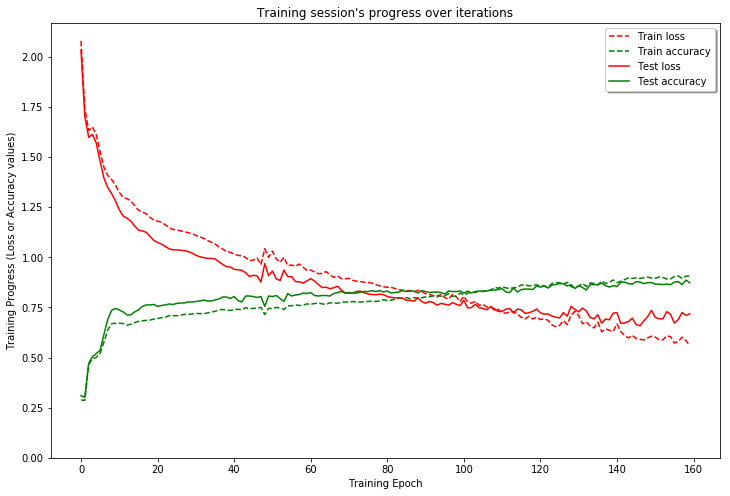

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")
plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

### 예측 결과를 나타낸 그래프입니다. 대각선이 각 행동을 올바르게 예측한 횟수입니다.

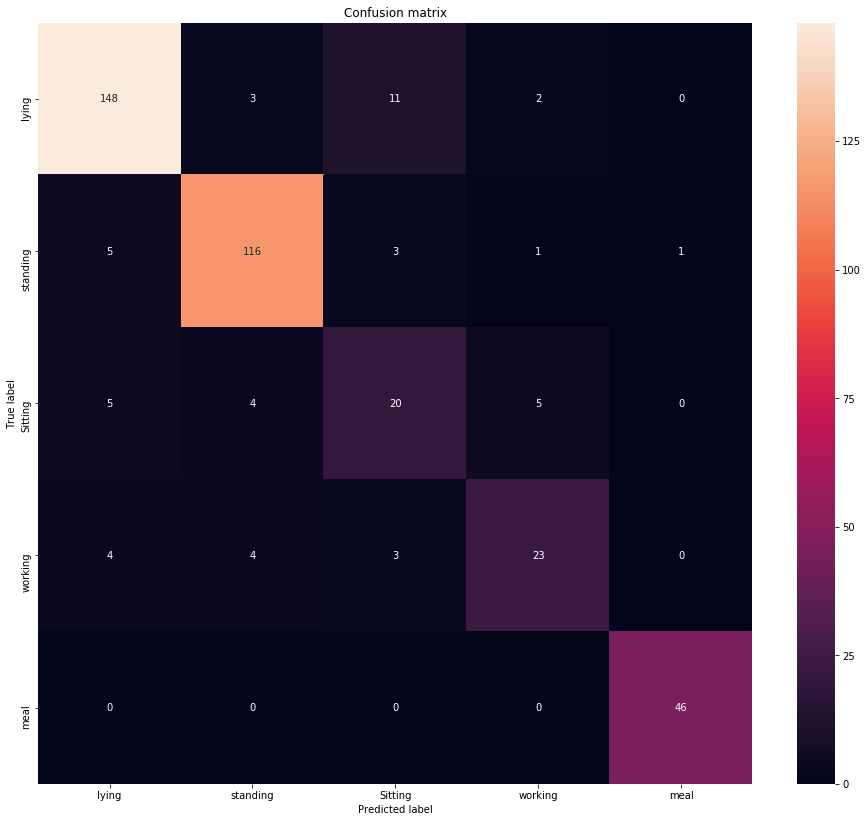

In [29]:
LABELS = ['lying', 'standing', 'Sitting','working','meal']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

### 편의를 위해 구현한 class 입니다. 

In [55]:
class Judge_activity():
    def __init__(self,data):
        sess=tf.Session() 
        saver.restore(sess, "/tmp/model.ckpt")
        
        data=data.rename(index=str, columns={"x-axis (deg/s)": "x", "y-axis (deg/s)": "y",'z-axis (deg/s)':'z'})
        
        for i in range(0, len(activity_df) - N_TIME_STEPS, step):
            xs = activity_df['x'].values[i: i + N_TIME_STEPS]
            ys = activity_df['y'].values[i: i + N_TIME_STEPS]
            zs = activity_df['z'].values[i: i + N_TIME_STEPS]
            segments.append([xs, ys, zs])
            
        reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
        
        predictions= sess.run(pred_softmax, feed_dict={X:reshaped_segments})
        self.pred=np.argmax(predictions, axis=1)
        self.pred_list=[]
    
    def get_predictions(self):
        return self.pred
    
    def recognition_act(self):
        tmp_list=[]
        for i in self.pred:
            if i==0 and len(tmp_list)==:
                print('Lying')
                tmp_list.append('Lying')
                
            elif i==1:
                print('Standing')
                tmp_list.append('Standing')
            elif i==2:
                print('Sitting')
                tmp_list.append('Sitting')
            elif i==3:
                print('Working')
                tmp_list.append('Working')
                
            elif i == 0 and tmp_list[-1] not in ('Standing','Working','Fall','Sleeping'):
                print('Lying')
                tmp_list.append('Lying')
                
            elif (tmp_list[-1] in ('Standing','Working') and i==0) or (set(tmp_list[-10:])!={'Fall'} and tmp_list[-1]=='Fall' and i==0):
                print('Fall')
                tmp_list.append('Fall')
            elif set(tmp_list[-10:])=={'Fall'} and i==0:
                print('Lying')
                tmp_list.append('Lying')
            elif i==4:
                print('Meal')
                tmp_list.append('Meal')
            elif i==0 and set(tmp_list[-1600:])=={'Lying'}:
                print('Sleeping')
                tmp_list.append('Sleeping')
            elif i==0 and tmp_list[-1]=='Sleeping':
                print('Sleeping')
                tmp_list.append('Sleeping')
        
        self.pred_list=tmp_list

### 아래와 같이 인스턴스를 생성하여 결과를 확인할 수 있습니다.

In [56]:
test=Judge_activity(activity_df)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


In [61]:
test.recognition_act()

Lying
Sitting
Lying
Lying
Standing
Fall
Sitting
Lying
Lying
Lying
Lying
Sitting
Sitting
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Sitting
Lying
Standing
Fall
Fall
Fall
Sitting
Sitting
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Sitting
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Sitting
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Sitting
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Sitting
Sitting
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Lying
Sitting
Sitting
Standing
Fall
Fall
Standing
Fall
Working
Working
Fall
Fall
Fall
Fall
Fall
Fall
Fall
Fall
Fall
Fall
Lying
Lying
L

Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Sitting
Working
Working
Working
Working
Working
Working
Working
Fall
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Fall
Working
Working
Fall
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Standing
Standing
Working
Working
Working
Working
Working
Standing
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Fall
Working
Fall
Sitting
Working
Sitting
Working
Working
Working
Working
Fall
Working
Working
Working
Working
Fall
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Working
Wo

Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Meal
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing

Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Fall
Sitting
Standing
Fall
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Sitting
Standing
Standing
Standing
Standing
Standing
St

In [62]:
test.pred

array([0, 2, 0, ..., 2, 1, 1], dtype=int64)